In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay, accuracy_score
import graphviz
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
import random

In [2]:
colleges_joined = pd.read_csv('cleaned_dataframe.csv')
profit_data = colleges_joined[['asian_or_pacific_share_fall_2000', 'black_share_fall_2000',
       'hisp_share_fall_2000', 'alien_share_fall_2000', 'par_median',
        'par_q1', 'par_top1pc', 'type']]

# print((profit_data.columns[profit_data.isnull().any()]))
profit_data = profit_data.dropna()

profit_col = profit_data['type']
profit_col = [0 if x==1 or x==0 else 1 for x in profit_col]
profit_data = profit_data.drop(columns='type')

train_x, test_x, train_y, test_y = train_test_split(profit_data, profit_col, train_size=.7)

In [108]:
param_grid = {'max_depth': [1,2,4,6,8,10],
              'min_samples_leaf': range(1, 15,2),
              'max_features':['auto', 'sqrt', 'log2']}
rf = RandomForestClassifier()
gs = GridSearchCV(rf, param_grid, scoring='f1', n_jobs=-1)
gs.fit(train_x, train_y)
preds = gs.predict(test_x)
print(gs.best_params_)
print(classification_report(test_y, preds))


{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5}
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       371
           1       0.76      0.67      0.72       286

    accuracy                           0.77       657
   macro avg       0.77      0.76      0.76       657
weighted avg       0.77      0.77      0.76       657



In [16]:
rf = RandomForestClassifier(max_depth=12, min_samples_leaf=5)

rf.fit(train_x, train_y)
rf_preds = rf.predict_proba(test_x)
importance = rf.feature_importances_
features = ['% asian or pacific islander',
            '% black',
            '% hispanic',
            '% nonresident alien',
            'median parent income',
            '% of students with parents in the bottom 20% of income distribution',
            '% of students with parents in the top 1% of income distribution']
rf_roc_preds = list()
for p in rf_preds:
    rf_roc_preds.append(p[1])
# rf_preds
rf_roc = roc_curve(test_y, rf_roc_preds)



In [22]:
def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    metric: sklearn metric, such as accuracy_score, precision_score or recall_score
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
#     bar=progressbar.ProgressBar(max_value=len(X.columns))
    print(clf)

    baseline_metric=metric(y, clf.predict(X))
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
            score=metric(y, clf.predict(X1))
            scores[c].append(baseline_metric-score)
#         bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores


d = (PermImportance(train_x, train_y, rf, accuracy_score))

RandomForestClassifier(max_depth=12, min_samples_leaf=5)


In [29]:
print(np.mean(d[1]['asian_or_pacific_share_fall_2000']))
print(np.mean(d[1]['black_share_fall_2000']))
print(np.mean(d[1]['hisp_share_fall_2000']))
print(np.mean(d[1]['alien_share_fall_2000']))
print(np.mean(d[1]['par_median']))
print(np.mean(d[1]['par_q1']))
print(np.mean(d[1]['par_top1pc']))



0.08792343387470998
0.04677494199535964
0.041189095127610216
0.0724941995359629
0.08687354988399075
0.11400812064965198
0.24499999999999997


In [9]:
rf_2 = RandomForestClassifier(max_depth=12, min_samples_leaf=5, criterion='entropy')

rf_2.fit(train_x, train_y)
rf_2preds = rf_2.predict(test_x)
print(classification_report(test_y, rf_2preds))


              precision    recall  f1-score   support

           0       0.80      0.77      0.79       373
           1       0.77      0.81      0.79       366

    accuracy                           0.79       739
   macro avg       0.79      0.79      0.79       739
weighted avg       0.79      0.79      0.79       739



In [57]:
linear = LogisticRegression()
linear.fit(train_x, train_y)
linear_preds = linear.predict_proba(test_x)
# linear_preds = [0 if pred<=.5 else 1 for pred in linear_preds]
linear_roc_preds = list()
for p in linear_preds:
    linear_roc_preds.append(p[1])

linear_roc = roc_curve(test_y, linear_roc_preds)


In [58]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(train_x, train_y)
knn_preds = knn.predict_proba(test_x)

knn_roc_preds = list()
for p in knn_preds:
    knn_roc_preds.append(p[1])

knn_roc = roc_curve(test_y, knn_roc_preds)

In [100]:
nb = GaussianNB()
nb.fit(train_x, train_y)
nb_preds = nb.predict(test_x)
print(classification_report(test_y, nb_preds))

nb_roc_preds = list()
for p in nb_preds:
    nb_roc_preds.append(p[1])
nb_roc = roc_curve(test_y, nb_roc_preds)

              precision    recall  f1-score   support

           0       0.64      0.92      0.75       371
           1       0.75      0.33      0.45       286

    accuracy                           0.66       657
   macro avg       0.69      0.62      0.60       657
weighted avg       0.69      0.66      0.62       657



IndexError: invalid index to scalar variable.

In [95]:
df = colleges_joined
mask = df['type'] == 2
for_profit = df[mask]
for_profit = for_profit['k_median'].dropna()
print(for_profit.mean())


df = colleges_joined
mask = df['type'] != 2
for_profit = df[mask]
for_profit = for_profit['k_median'].dropna()
print(for_profit.mean())

44609.76800976801
32340.925524222705


# TODO: add more subheadings

# Question 2 Is there a relation between for-profit schools and racial and economic factors?

There is the stereotype that for-profit schools take advantage of people. In this question we are explore if there is a relation between if a school is a for-profit and the percent of students from certain races and income levels. In this section we use four different classification techniques: Naive Bayes, K-Nearest Neighbors, Logistic Regression, and Random Forests. For all of the models we use the sci-kit learn implementation. 

We use the following features, percentage of students attending the school of the ethnicities: Asian and Pacific Islanders, Hispanic, Nonresident aliens, and Blacks. As well as Parents median income, students whose parents are in the bottom 20% of the income distribution, and students whose parents are in the top 1% of the income distribution to predict if a school is for-profit or public/private non-profit.
## Models
First we will discuss the results of the K-Nearest Neighbors. The KNN model performed the worst of all the models resulting in only a 61% accuracy suggesting that they are not in proximity of each other. Naive Bayes did not perform much better with a 66% accuracy. The Logistic Regression performed better with an accuracy score 74% suggesting that they cannot be linearly separated very well. The Random Forest performed the best out of the three with an accuracy of 81%. In the following analysis we use the Random Forest model.

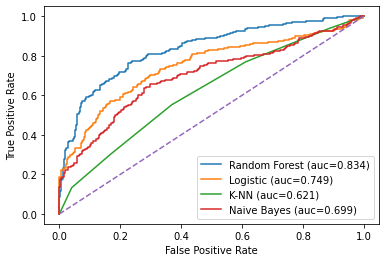

In [99]:
plt.plot(rf_roc[0], rf_roc[1], label='Random Forest (auc=' + str(round(auc(rf_roc[0], rf_roc[1]), 3)) + ')')
plt.plot(linear_roc[0], linear_roc[1], label='Logistic (auc=' + str(round(auc(linear_roc[0], linear_roc[1]), 3)) + ')')
plt.plot(knn_roc[0], knn_roc[1], label='K-NN (auc=' + str(round(auc(knn_roc[0], knn_roc[1]), 3)) + ')')
plt.plot(nb_roc[0], nb_roc[1], label='Naive Bayes (auc=' + str(round(auc(nb_roc[0], nb_roc[1]), 3)) + ')')
plt.plot([0,1], [0,1], '--')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='lower right')
plt.show()

When looking at the importance of the features we notice that where the parents are in the income distribution is the most important. The percent of students that are Asian or Pacific Islander is the next most important feature followed closely by parents median income. The last three racial factors, Nonresident Alien, Hispanic, and Black are the least important factors. 

Feature 0: % asian or pacific islander, Score: 0.12792
Feature 1: % black, Score: 0.07176
Feature 2: % hispanic, Score: 0.08620
Feature 3: % nonresident alien, Score: 0.11176
Feature 4: median parent income, Score: 0.14255
Feature 5: % of students with parents in the bottom 20% of income distribution, Score: 0.19997
Feature 6: % of students with parents in the top 1% of income distribution, Score: 0.25985


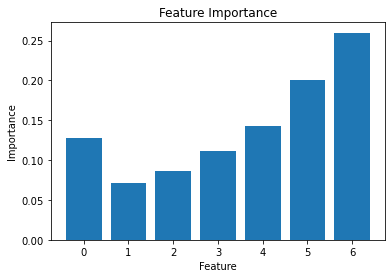

In [6]:
for i,(f,v) in enumerate(zip(features, importance)):
    print('Feature %0d: %s, Score: %.5f' % (i,f,v))
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

We found that we are able to reasonably predict wether a school is for-profit or non-profit based on a combination of economic and racial factors of the schools demographics. This suggests that there is a correlation between these factors and if a school is for-profit or non-profit. The parents economic status are the most important factors in determining what type of school it is. However some racial factors do have an impact.